# Part A: Probabilistic Gaussian Generative Classifier

## Imports

In [2]:
import sklearn as sk
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Computing Metrics

A class to record accuracy, precision, recall and f1 score

In [3]:
class MetricsEvaluation:
    def __init__(self, y_actual, y_predicted):
        self.y_actual= y_actual
        self.y_predicted=y_predicted
        self.classes = np.unique(y_actual)
        self.k = len(self.classes)
        self.cm = np.zeros((self.k, self.k), dtype=int)
        self._compute_cm()
        self._compute_macro_metrics()
        
        
    def _compute_cm(self):
         for actual, pred in zip(self.y_actual, self.y_predicted):
            self.cm[actual, pred] += 1
             
    def _compute_macro_metrics(self):
        precisions = []
        recalls = []
        f1s = []
        # Compute metrics per class
        for k in self.classes:
            TP = self.cm[k, k]
            FP = np.sum(self.cm[:, k]) - TP
            FN = np.sum(self.cm[k, :]) - TP
            precision = TP / (TP + FP)
            recall = TP / (TP + FN) 
            f1_score = 2 * precision * recall / (precision + recall)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1_score)
        # compute macro-averaged values
        self.macro_precision = np.mean(precisions)
        self.macro_recall = np.mean(recalls)
        self.macro_f1 = np.mean(f1s)
        # compute accuracy
        self.accuracy = np.mean(self.y_actual == self.y_predicted)

    def get_macro_metrics(self):
        return self.accuracy,self.macro_precision, self.macro_recall, self.macro_f1

    def get_confusion_matrix(self):
        return self.cm
    def report_metrics(self):
        print(f"Accuracy: {self.accuracy}\n"
      f"Macro-Averaged Precision: {self.macro_precision}\n"
      f"Macro-Averaged Recall: {self.macro_recall}\n"
      f"Macro-Averaged F1-Score: {self.macro_f1}")



## A1. Dataset and Setup

Load dataset

In [4]:
digits = load_digits()
X,y = digits.data, digits.target

In [5]:
X.shape, y.shape

((1797, 64), (1797,))

Split dataset into 70% and 30%

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

Split 30% into 15% validation and 15% test

In [7]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

Standarize features

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

Combine train and validation sets for final evaluation

In [9]:
x_combined = np.vstack([X_train_scaled, X_val_scaled])
y_combined = np.hstack([y_train, y_val])

## A2. Gaussian Generative Model

In [10]:
class GaussianGenerativeModel():
    def __init__(self,x_train,y_train):
        self.x_train = x_train
        self.y_train = y_train
        self.d = self.x_train.shape[1]
        self.pi = np.zeros(10) # Class priors
        self.mu = np.zeros((10, self.d)) # Class means
        self.sigma = np.zeros((self.d, self.d)) # Covariance matrix
        self.sigma_reg = np.zeros((self.d, self.d)) # Regularized covariance matrix
    def _estimate_class_priors(self):
        n = len(self.y_train)
        for k in range(10):
            pi_k = np.sum(self.y_train == k)/n
            self.pi[k] = pi_k
        return self.pi
    def _estimate_class_means(self):
        for k in range(10):
            x_class = self.x_train[self.y_train == k] # Get all samples that are equal to k
            mu_k = x_class.mean(axis=0) # return a vector of size 64x1
            self.mu[k] = mu_k
    def _estimate_covariance_matrix(self):
        self.sigma = np.zeros((self.d, self.d)) 
        # Iterate over training samples
        for i in range(len(self.y_train)):
            # compute the difference
            diff = self.x_train[i] - self.mu[self.y_train[i]]
            # create a diagonal matrix
            self.sigma += np.outer(diff,diff)
        self.sigma /= len(self.y_train)
    def regularize(self,reg_term=0):
        self.sigma_reg = self.sigma + reg_term * np.eye(self.d)
    def fit(self, reg_term=0):
        self._estimate_class_priors()
        self._estimate_class_means()
        self._estimate_covariance_matrix()
        self.regularize(reg_term)
    def _predict(self,x):
        scores =np.zeros(10)
        for k in range(10):
            diff = x - self.mu[k]
            score = np.log(self.pi[k]) - 0.5 * (diff.T @ np.linalg.solve(self.sigma_reg, diff))
            scores[k]= score
        prediction = np.argmax(scores)
        return prediction
    def predict(self,x_test):
        predictions = [self._predict(x) for x in x_test]
        return np.array(predictions)

            

## A3. Hyperparameter Tuning and Evaluation

Test different regularization terms 

In [11]:
reg_term_values = [10,1,0.5,1e-1,1e-2,1e-6]

In [12]:
accuracies=[]
for reg in reg_term_values:
    model = GaussianGenerativeModel(X_train_scaled, y_train) 
    model.fit(reg)
    predictions =  model.predict(X_val_scaled)
    # compute accuracy
    accuracy = np.mean(predictions == y_val)
    accuracies.append(accuracy)
for accuracy in accuracies:
    print(accuracy)

0.8481481481481481
0.9222222222222223
0.9296296296296296
0.9444444444444444
0.9444444444444444
0.9444444444444444


Record the best validation accuracy and its corresponding regularization term

In [13]:
val_accuracy = max(accuracies)
best_reg = reg_term_values[np.argmax(accuracies)]
print(f"Best validation accuracy is {val_accuracy} at λ = {best_reg}")

Best validation accuracy is 0.9444444444444444 at λ = 0.1


Get the final model based on the best values

In [14]:
best_model = GaussianGenerativeModel(x_combined, y_combined)
best_model.fit(best_reg)
y_pred = best_model.predict(X_test_scaled)

Evaluate the final model

In [15]:
metrics_eval = MetricsEvaluation(y_test,y_pred)

In [16]:
metrics_eval.report_metrics()

Accuracy: 0.9629629629629629
Macro-Averaged Precision: 0.9631904761904762
Macro-Averaged Recall: 0.9626577126577127
Macro-Averaged F1-Score: 0.9624803472389681


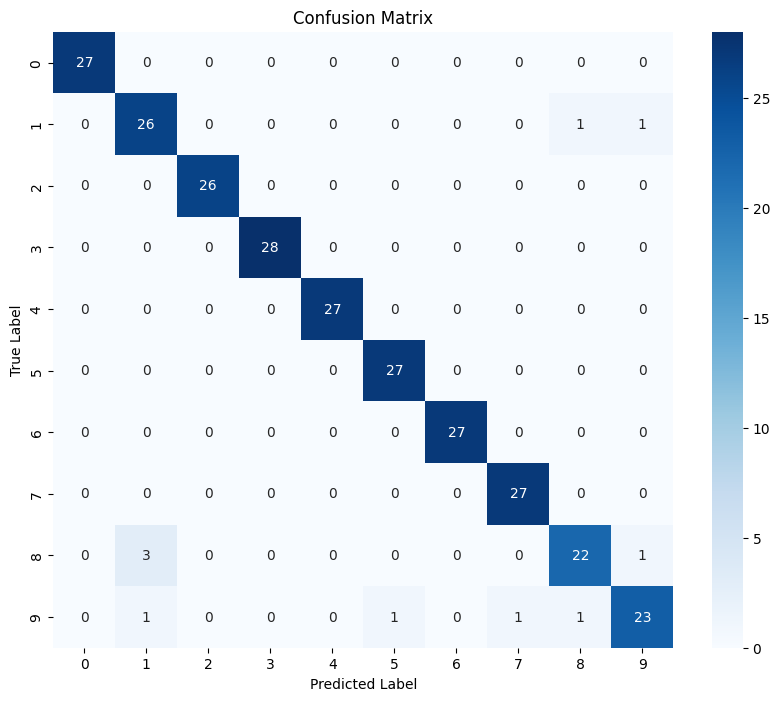

In [17]:
cm = metrics_eval.get_confusion_matrix()
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()